In [10]:
####################### IMPORTING ALL LIBRARIES #############################

# Core
import os
import re
import json
import random
import itertools

# Math & Analysis
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Image Processing
from PIL import Image, ImageDraw

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Vision
import torchvision.models as models
import torchvision.transforms as transforms

# Machine Learning
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances

# Similarity Search
import faiss

# Language Modeling
from typing import List
from anthropic import Anthropic


# HTTP Requests
import requests
from dotenv import load_dotenv

##########################################################################
# Setting working directory
os.chdir("/Users/hannahkim/Desktop/SCHOOL/GEORGETOWN/DSAN-6725/spring-2025-final-project-project-group-4")
print("Current working directory:", os.getcwd())

Current working directory: /Users/hannahkim/Desktop/SCHOOL/GEORGETOWN/DSAN-6725/spring-2025-final-project-project-group-4


Current temperature in Washington: 26°C (79°F)

Using temperature: 26°C (79°F)
Occasion detected: casual

Weather recommendation: It's warm/hot outside (26°C/79°F), so t-shirts and short sleeve shirts are recommended for comfort. Pants or shorts would both work for bottoms.


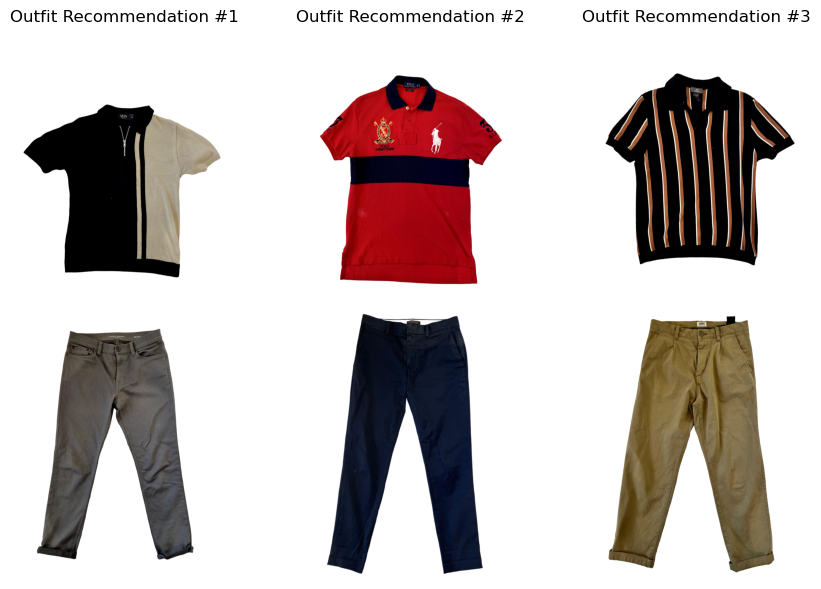


Your Personal Stylist Says:
Hey there, stylish buddy! Let's take a look at those outfit options:

Outfit 1: This one gives off a nice, laidback vibe. The beige shirt and khaki pants create a classic, casual look that's perfect for a relaxed day. It's a safe, versatile choice.

Outfit 2: This one is a bit bolder with the red shirt. It's still casual, but the pop of color adds some energy to the outfit. If you're feeling a bit more adventurous, this could be a good pick.

Outfit 3: The black shirt and khaki pants in this one give off a slightly more dressed-up, almost semi-formal vibe. It's still casual, but it's a bit more polished than the other two.

Hmm, for the temperature and the "casual" brief, I'd probably go with Outfit 1. The beige and khaki combo is super chill and comfortable, perfect for a casual day. It's a safe bet that still looks put-together. But if you're in the mood to switch it up, Outfit 2 with the red shirt could be a fun, bold choice. Let me know what you think!


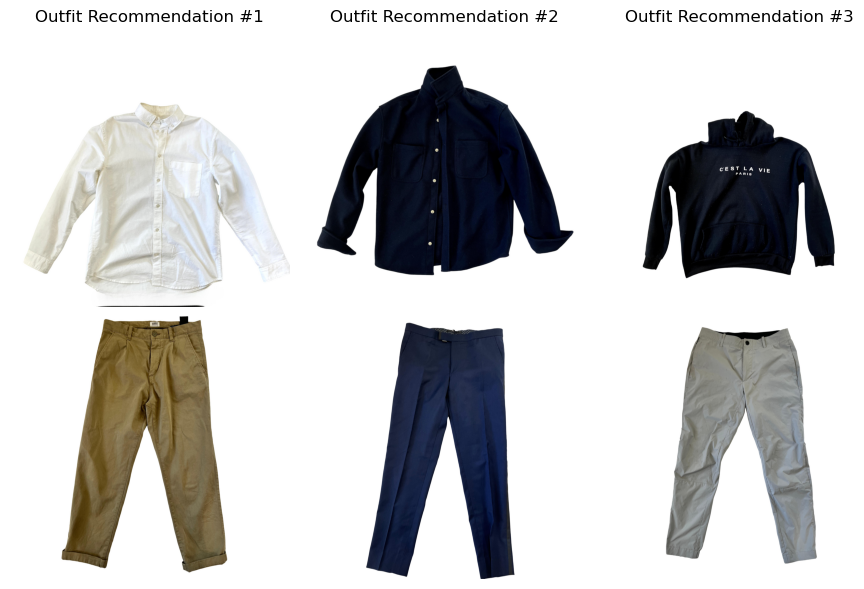


Your Personal Stylist Says:
Okay, let's take a look at these outfits!

Outfit 1:
This gives off a more casual, laid-back vibe. The white shirt and khaki pants are a classic combo, but it's not super formal. It's a good option if you want to feel comfortable and relaxed.

Outfit 2: 
This is a bit more formal with the navy shirt and pants. It has a polished, professional look. This would be a good choice if you need to look sharp, like for a meeting or event.

Outfit 3:
This one is a little more casual and sporty. The black shirt and gray pants have a bit of an athleisure feel. It's a good option if you want to feel confident and a little edgy.

For the 26°C/79°F weather, I'd probably go with Outfit 2. The navy is a nice, cool color for the heat, and the formal vibe is perfect if you need to look put-together. Plus, the long sleeves will keep you comfortable.

Let me know if you have any other questions! I'm happy to help you put together the perfect outfit.

Top locked from Outfit 1!



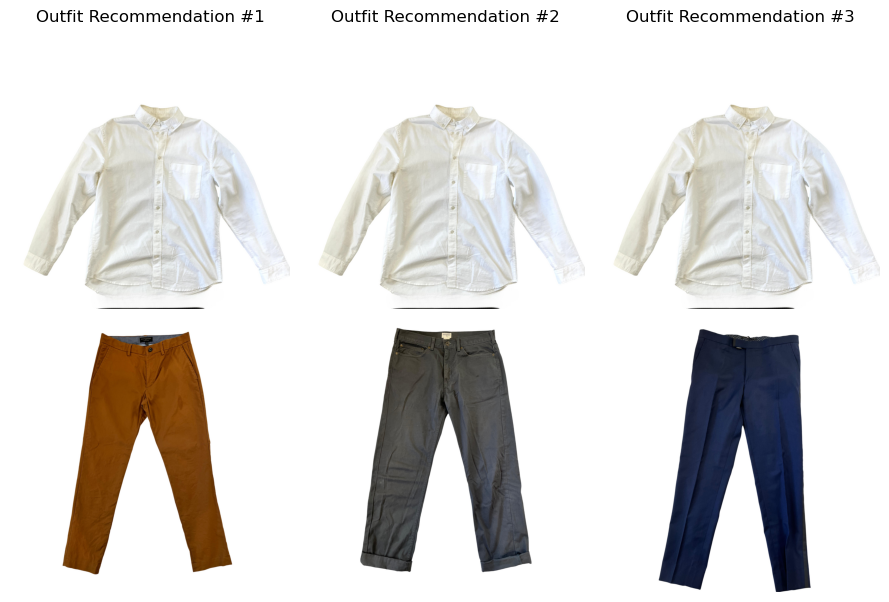


Your Personal Stylist Says:
Alright, let's break down these outfit options:

Outfit 1:
This gives off a more casual, laid-back vibe with the white shirt and orange casual pants. It's a bit too casual for a more formal setting.

Outfit 2: 
The white shirt and charcoal pants give a slightly more formal look, but still have a casual edge to them. This could work for a semi-formal event.

Outfit 3:
Now this is the winner! The white shirt and navy formal pants create a sleek, polished look that's perfect for a more formal occasion. The navy pants really elevate the outfit.

My verdict: Go with Outfit 3. The navy formal pants paired with the white shirt gives you a sharp, put-together vibe that's suitable for a more formal event in the 26°C/79°F weather. It strikes the right balance between style and formality.

Bye! Stay stylish.


In [11]:
load_dotenv()
client = Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))

# Load clothing data and embeddings
with open("Parsa/testing_code/clothing_embeddings.json") as f:
    clothing_data = json.load(f)

metadata_list = []
embedding_list = []

for item in clothing_data:
    metadata_list.append({k: item[k] for k in item if k != "embedding"})
    embedding_list.append(item["embedding"])

embedding_array = np.array(embedding_list).astype("float32")

# Create FAISS index
embedding_dim = embedding_array.shape[1]
faiss_index = faiss.IndexFlatL2(embedding_dim)
faiss_index.add(embedding_array)

# Weather Tool
class WeatherTool:
    def __init__(self):
        self.api_key = "f1283ef123b044ce41499b0b3fe12241"

    def get_temperature(self, city="Washington,DC", country="US"):
        url = f"http://api.openweathermap.org/data/2.5/weather?q={city},{country}&appid={self.api_key}&units=metric"
        response = requests.get(url)
        data = response.json()
        if "main" in data:
            celsius = round(data["main"]["temp"])
            fahrenheit = round((celsius * 9/5) + 32)
            return celsius, fahrenheit
        else:
            raise ValueError(f"Failed to fetch weather data: {data}")

# Occasion Parser
def parse_occasion(user_input):
    user_input = user_input.lower()
    if any(word in user_input for word in ["date", "romantic"]):
        return "date night"
    if any(word in user_input for word in ["interview", "meeting"]):
        return "job interview"
    if any(word in user_input for word in ["beach", "walk"]):
        return "beach walk"
    if any(word in user_input for word in ["chill", "weekend", "hang"]):
        return "chill weekend hang"
    if any(word in user_input for word in ["formal"]):
        return "formal"
    if any(word in user_input for word in ["gym", "run", "sporty"]):
        return "sporty"
    return "casual"

# Wardrobe Filter 
def filter_wardrobe(wardrobe, temperature, occasion, color_preference=None):
    suitable = []
    for item in wardrobe:
        item_styles = item.get("style", [])
        if isinstance(item_styles, str):
            item_styles = [item_styles]
        
        # Check if the item matches the occasion
        occasion_match = occasion in item_styles or "casual" in item_styles
        
        if occasion_match:
            # Apply strict temperature filtering
            if temperature < 10:  # Cold
                # Long sleeves and pants only
                if item["category"] == "pants" or (item["category"] in ["shirt", "t-shirt"] and item.get("sleeve", "") == "long"):
                    suitable.append(item)
            
            elif 10 <= temperature < 20:  # Cool
                if occasion.lower() == "formal":
                    # Formal in cool weather: long sleeves and pants
                    if item["category"] == "pants" or (item["category"] in ["shirt", "t-shirt"] and item.get("sleeve", "") == "long"):
                        suitable.append(item)
                else:
                    # Casual in cool weather: any sleeve type and pants
                    if item["category"] == "pants" or item["category"] in ["shirt", "t-shirt"]:
                        suitable.append(item)
            
            else:  # Warm/Hot (20+)
                if occasion.lower() == "formal":
                    # Formal in warm weather: still needs long sleeves and pants
                    if item["category"] == "pants" or (item["category"] in ["shirt", "t-shirt"] and item.get("sleeve", "") == "long"):
                        suitable.append(item)
                else:
                    # Casual in warm weather: ONLY short sleeves or t-shirts, pants or shorts
                    if item["category"] in ["pants", "shorts"] or \
                       (item["category"] in ["shirt", "t-shirt"] and (item.get("sleeve", "") == "short" or item["category"] == "t-shirt")):
                        suitable.append(item)
    
    # Apply color preference if specified
    if color_preference:
        if color_preference in ["dark", "bright"]:
            color_filtered = [item for item in suitable if color_preference in item.get("color", "").lower()]
            if color_filtered:  # Only use color filtered if we found matches
                suitable = color_filtered
        else:
            color_filtered = [item for item in suitable if color_preference.lower() in item.get("color", "").lower()]
            if color_filtered:  # Only use color filtered if we found matches
                suitable = color_filtered
    
    return suitable

def recommend_based_on_weather(temperature, occasion):
    """
    Provides clothing recommendations based on temperature and occasion.
    
    Args:
        temperature (int): Temperature in Celsius
        occasion (str): The occasion type (casual, formal, etc.)
        
    Returns:
        dict: Recommended clothing categories with explanations
    """
    # Calculate Fahrenheit for display
    fahrenheit = round((temperature * 9/5) + 32)
    
    # Initialize recommendations
    recommendations = {
        "tops": [],
        "bottoms": [],
        "explanation": ""
    }
    
    # Cold weather (less than 10°C/50°F)
    if temperature < 10:
        recommendations["tops"] = ["long sleeve shirts"]
        recommendations["bottoms"] = ["pants"]
        recommendations["explanation"] = f"It's cold outside ({temperature}°C/{fahrenheit}°F), so I recommend long sleeve shirts and pants to stay warm."
    
    # Cool weather (10-20°C/50-68°F)
    elif 10 <= temperature < 20:
        if occasion.lower() == "formal":
            recommendations["tops"] = ["long sleeve shirts"]
            recommendations["bottoms"] = ["pants"]
            recommendations["explanation"] = f"For this cool weather ({temperature}°C/{fahrenheit}°F) formal occasion, long sleeve shirts and pants are appropriate."
        else:
            recommendations["tops"] = ["long sleeve shirts", "short sleeve shirts"]
            recommendations["bottoms"] = ["pants"]
            recommendations["explanation"] = f"The temperature is cool ({temperature}°C/{fahrenheit}°F), so long sleeve shirts are recommended, but short sleeves are also fine if you're comfortable. Pants are best for the bottom."
    
    # Warm/Hot weather (20°C/68°F and above)
    else:  # temperature >= 20
        if occasion.lower() == "formal":
            recommendations["tops"] = ["long sleeve shirts"]
            recommendations["bottoms"] = ["pants"]
            recommendations["explanation"] = f"Although it's warm ({temperature}°C/{fahrenheit}°F), since this is a formal occasion, I recommend long sleeve shirts and pants."
        else:
            recommendations["tops"] = ["t-shirts", "short sleeve shirts"]  # Only short sleeves for warm weather
            recommendations["bottoms"] = ["pants", "shorts"]
            recommendations["explanation"] = f"It's warm/hot outside ({temperature}°C/{fahrenheit}°F), so t-shirts and short sleeve shirts are recommended for comfort. Pants or shorts would both work for bottoms."
    
    return recommendations

# Generate Recommendations
def generate_outfit_recommendations(user_input, temperature, gender, outfits: List[List[dict]]):

    fahrenheit = round((temperature * 9/5) + 32)

    prompt = f"""
Hey, you're my stylish buddy helping me get dressed.
I'm a {gender} and I'm trying to figure out what to wear.

Here’s the situation:
"{user_input}" (temperature is {temperature}°C / {fahrenheit}°F)

Here are three outfit combos I’m considering:
"""

    for i, outfit in enumerate(outfits):
        prompt += f"\nOutfit {i+1}:\n{json.dumps(outfit, indent=2)}\n"

    prompt += """
For each one, tell me what kind of vibe it gives off — like if I want to feel chill, sporty, bold, etc.
Then give me your final verdict on which one to wear and why. Keep it casual and short, like we're texting.
"""

    completion = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=300,
        temperature=0.8,
        messages=[{"role": "user", "content": prompt}]
    )

    return [completion.content[0].text.strip()]

# Visual Display
def display_selected_outfit(outfits):
    category_folder_map = {
        "shirt": "shirts",
        "t-shirt": "t-shirts",
        "pants": "pants",
        "shorts": "shorts"
    }

    num_outfits = len(outfits)
    fig, axs = plt.subplots(2, num_outfits, figsize=(3 * num_outfits, 6), gridspec_kw={'hspace': 0.0})

    for col, outfit in enumerate(outfits):
        for row, item in enumerate(outfit):
            path = os.path.join("Parsa/parsa's_wardrobe", category_folder_map[item["category"]], item["filename"])
            img = Image.open(path).convert("RGB")
            axs[row, col].imshow(img)
            axs[row, col].axis("off")

    for col in range(num_outfits):
        axs[0, col].set_title(f"Outfit Recommendation #{col + 1}", fontsize=12, pad=10)

    plt.subplots_adjust(hspace=0)
    plt.tight_layout()
    plt.show()

# Outfit Agent
def outfit_agent(user_input, temperature, gender="male", refresh=False, lock_top=None, lock_bottom=None, color=None):
    occasion = parse_occasion(user_input)
    
    # Calculate Fahrenheit for display
    fahrenheit = round((temperature * 9/5) + 32)
    
    print(f"\nUsing temperature: {temperature}°C ({fahrenheit}°F)")
    print(f"Occasion detected: {occasion}\n")
    
    # Get weather-based recommendations
    weather_recs = recommend_based_on_weather(temperature, occasion)
    print(f"Weather recommendation: {weather_recs['explanation']}")
    
    # Filter wardrobe based on weather recommendations and occasion
    filtered = filter_wardrobe(metadata_list, temperature, occasion, color)
    
    # If locked items exist, verify they meet weather criteria (except for formal occasions)
    if lock_top and lock_top["category"] in ["shirt", "t-shirt"]:
        if temperature >= 20 and occasion.lower() != "formal" and lock_top.get("sleeve", "") == "long":
            print("Warning: Your locked top has long sleeves which may be too warm for this weather.")
            print("Consider unlocking it or choosing a formal occasion if you want to wear it.")
    
    tops = [item for item in filtered if item["category"] in ["shirt", "t-shirt"]]
    bottoms = [item for item in filtered if item["category"] in ["pants", "shorts"]]
    
    # Safety check - make sure we have items to work with
    if not tops or not bottoms:
        print("No suitable items found with your current criteria. Relaxing some constraints...")
        # Fall back to basic occasion filtering without strict temperature rules
        filtered = [item for item in metadata_list if occasion in item.get("style", []) or "casual" in item.get("style", [])]
        tops = [item for item in filtered if item["category"] in ["shirt", "t-shirt"]]
        bottoms = [item for item in filtered if item["category"] in ["pants", "shorts"]]
    
    if refresh:
        random.shuffle(tops)
        random.shuffle(bottoms)
    
    combinations = []
    for i in range(min(3, len(tops), len(bottoms))):
        top = lock_top if lock_top else tops[i]
        bottom = lock_bottom if lock_bottom else bottoms[i]
        combinations.append([top, bottom])
    
    responses = generate_outfit_recommendations(user_input, temperature, gender, combinations)
    display_selected_outfit(combinations)
    
    for i, res in enumerate(responses):
        print(f"\nYour Personal Stylist Says:\n{res}\n")
    
    return combinations

# Chat Loop
def chat_loop():
    combos = []
    locked_top = None
    locked_bottom = None
    color_preference = None

    # ✅ Fetch the temperature once before the loop starts
    weather_tool = WeatherTool()
    celsius_temp, fahrenheit_temp = weather_tool.get_temperature("Washington,DC", "US")
    print(f"Current temperature in Washington: {celsius_temp}°C ({fahrenheit_temp}°F)")

    while True:
        user_input = input("\nYou: ").strip().lower()

        if user_input in ["exit", "quit", "bye"]:
            print("Bye! Stay stylish.")
            break

        # Handle update weather request
        if "update weather" in user_input or "check weather" in user_input:
            try:
                celsius_temp, fahrenheit_temp = weather_tool.get_temperature("Washington", "US")
                print(f"Current temperature in Washington: {celsius_temp}°C ({fahrenheit_temp}°F)")
                continue
            except Exception as e:
                print(f"Could not update weather: {e}")
                continue

        if "unlock" in user_input:
            if "pants" in user_input:
                locked_bottom = None
                print("Unlocked pants.")
            if "shirt" in user_input or "top" in user_input:
                locked_top = None
                print("Unlocked top.")
            continue

        if "lock" in user_input:
            if "pants" in user_input or "bottom" in user_input:
                try:
                    # More robust pattern matching for the outfit number
                    match = re.search(r'(\d+)', user_input)
                    if match:
                        idx = int(match.group(1)) - 1
                        locked_bottom = combos[idx][1]
                        print(f"Pants locked from Outfit {idx + 1}!")
                    else:
                        print("Please specify which outfit number to lock (e.g., 'lock pants 2')")
                except Exception as e:
                    print("Could not lock pants:", e)
                continue

            if "shirt" in user_input or "top" in user_input:
                try:
                    # More robust pattern matching for the outfit number
                    match = re.search(r'(\d+)', user_input)
                    if match:
                        idx = int(match.group(1)) - 1
                        locked_top = combos[idx][0]
                        print(f"Top locked from Outfit {idx + 1}!")
                    else:
                        print("Please specify which outfit number to lock (e.g., 'lock top 2')")
                except Exception as e:
                    print("Could not lock top:", e)
                continue

        # if "lock" in user_input:
        #     if "pants" in user_input:
        #         try:
        #             idx = int(user_input.split("outfit")[-1].strip()) - 1
        #             locked_bottom = combos[idx][1]
        #             print(f"Pants locked from Outfit {idx + 1}!")
        #         except Exception as e:
        #             print("Could not lock pants:", e)
        #         continue

        #     if "shirt" in user_input or "top" in user_input:
        #         try:
        #             idx = int(user_input.split("outfit")[-1].strip()) - 1
        #             locked_top = combos[idx][0]
        #             print(f"Top locked from Outfit {idx + 1}!")
        #         except Exception as e:
        #             print("Could not lock top:", e)
        #         continue

        if any(word in user_input for word in ["blue tops", "red tops", "green tops"]):
            color_preference = user_input.split(" ")[0]
            print(f"Color preference set to {color_preference} for tops.")

        elif "dark tops" in user_input or "bright tops" in user_input:
            color_preference = "dark" if "dark" in user_input else "bright"
            print(f"Color preference set to {color_preference}.")

        elif "no color" in user_input:
            color_preference = None
            print("Color preference cleared.")

        combos = outfit_agent(
            user_input,
            temperature=celsius_temp,
            refresh=True,
            lock_top=locked_top,
            lock_bottom=locked_bottom,
            color=color_preference
        )
# Run it
chat_loop()


In [36]:
import json

# Load metadata
with open("Parsa/parsa's_wardrobe/metadata.json") as f:
    metadata = json.load(f)

# Extract and count unique colors
color_set = set()

for category_items in metadata.values():
    for item in category_items:
        color = item.get("color")
        if color:
            color_set.add(color.lower().strip())

print(f"Total distinct colors: {len(color_set)}")
print("Distinct colors:", sorted(color_set))

Total distinct colors: 16
Distinct colors: ['beige', 'black', 'blue', 'brown', 'charcoal', 'gray', 'khaki', 'light blue', 'mustard', 'navy', 'olive', 'orange', 'peach', 'red', 'teal', 'white']
